In [190]:
import imp

import pandas as pd
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import axelrod as axl
import axelrod.interaction_utils as iu

import testzd as zd

C, D = axl.Action.C, axl.Action.D

In [191]:
parameters = imp.load_source('parameters', 'data/raw/parameters.py')

# Investigate whether or not a strategy is zero determinant.

In [1], given a match between 2 memory one strategies the concept of Zero Determinant strategies is introduced. This result showed that a player $p\in\mathbb{R}^4$ against a player $q\in\mathbb{R}^4$ could force a linear relationship between the scores.

Assuming the following:

- The utilities for player $p$: $S_x = (R, S, T, P)$ and for player $q$: $S_y = (R, T, S, P)$.
- The normalised long run score for player $p$: $s_x$ and for player $q$: $s_y$.
- Given $p=(p_1, p_2, p_3, p_4)$ a transformed (but equivalent) vector: $\tilde p=(p_1 - 1, p_2 - 1, p_3, p_4)$, similarly: $\tilde q=(1 - q_1, 1 - q_2, q_3, q_4)$

The main result of [1] is that:

if $\tilde p = \alpha S_x + \beta S_y + \gamma 1$ **or** if $\tilde q = \alpha S_x + \beta S_y + \gamma 1$ then:

$$
\alpha s_x + \beta s_y + \gamma 1 = 0
$$

where $\alpha, \beta, \gamma \in \mathbb{R}$

The question arises:

**Given a strategy $p$, is it a zero determinant strategy?**

This is equivalent to finding $\alpha, \beta, \gamma \in \mathbb{R}$ such that $\tilde p = \alpha S_x + \beta S_y + \gamma 1$.

Recall that $\tilde p, S_x, S_y, 1\in\mathbb{R}^{4\times 1}$ so this corresponds to a linear system of 4 equations on three variables.

$$\tilde p=Mx$$

Where:

$$
M = \begin{pmatrix}S_x, S_y, 1\end{pmatrix}\in\mathbb{R}^{4\times 3}
$$

As an example consider the `extort-2` strategy defined in [2]. This is given by:

$$p=(8/9, 1/2, 1/3, 0)$$

it is defined to ensure:

$$
\begin{aligned}
\alpha s_x - P &= 2(s_y - P)\\
\alpha s_x - 2s_y + P&=0\\
\end{aligned}
$$

Let us solve $Mx=\tilde p$

In [223]:
p = np.array([8 / 9, 1 / 2, 1 / 3, 0])
zd.is_delta_ZD(p, delta=10 ** -7)

True

Note that the following vector is not:

$$p = (8 / 9, 1, 1 / 3, 0)$$

In [224]:
zd.is_delta_ZD(np.array([8 / 9, 1, 1 / 3, 0]), delta=10 ** -7)

False

Furthermore we can simulate the play of strategies and measure the probabilities:

In [225]:
players = axl.ZDExtort2(), axl.Alternator()
match = axl.Match(players, turns=10 ** 6)
axl.seed(0)
interactions = match.play()

In [226]:
def get_p_from_interactions(interactions):
    state_counter = iu.compute_state_to_action_distribution(interactions)[0]
    p = []
    for state in ((C, C), (C, D), (D, C), (D, D)):
        try:
            p.append(state_counter[(state, C)] / (state_counter[(state, C)]  + state_counter[(state, D)] ) )
        except ZeroDivisionError:
            p.append(np.NaN)
    return np.array(p)

In [227]:
p = get_p_from_interactions(interactions=interactions)
p

array([0.88787388, 0.49963841, 0.33404832, 0.        ])

We see that that measure of $p$ is not $\delta$-ZD for $\delta=10 ^ {-7}$:

In [228]:
zd.is_delta_ZD(p, delta=10 ** -7)

False

However it is for $\epsilon=10 ^ {-2}$:

In [229]:
zd.is_delta_ZD(p, delta=10 ** -2)

True

In fact the lowest $\delta$ for which $p$ is $\delta$-ZD is $\delta=10 ^ {-3}$:

In [230]:
zd.compute_least_squares(p)

(array([ 0.05551368, -0.1113683 ,  0.05606306]), 7.820132773632805e-07)

## Dealing with missing states

When observing strategies it is possible that some pairs of strategies do not visit all potential states. For example a cooperator against a defector will never visit the state $(\text{D}, \text{C})$. On these occasions, the $\delta$-ZD definition can be modified. Given a set of visited states $S\subseteq \{\text{C}, \text{D}\} ^2$: we define:

$$
M', \tilde p'
$$

where $M', p'$ corresponds to the rows/elements of $M, \tilde p$ that are in $S$.

As before, we can then find the best fitting $\bar x=(\bar\alpha, \bar\beta, \bar\gamma)$ which minimises:

$$
R^2 = \|M' x-\tilde p'\|_2= \sum_{i\text{ corresponding to }S}\left((M\bar x)_i-\tilde p_i\right)^2
$$

For example let us consider a match between a cooperator and the `extort-2` strategy:

In [231]:
players = axl.ZDExtort2(), axl.Cooperator()
match = axl.Match(players, turns=10 ** 6)
axl.seed(0)
interactions = match.play()
p = get_p_from_interactions(interactions)
p

array([0.88902872,        nan, 0.3330999 ,        nan])

In [232]:
zd.is_delta_ZD(p, delta=10 ** -7)

True

Note however that in the case of $|S|>1$ (ie there are any missing states) then there exists a unique solution to the corresponding equations: thus, technically in the case of missing states **all** strategies are in fact $\delta$-ZD for all $\delta\geq 0$.

https://en.wikipedia.org/wiki/Rouch%C3%A9%E2%80%93Capelli_theorem

## Empirical observation

Let us measure the probabilities from two tournaments:

- The Stewart and Plotkin tournament of [2] which was written as a follow on to [1] highligting the impact of ZD strategies.
- A full tournament from the Axelrod Python project ([3] described in [4]): an open source library with over 200 strategies contributed from academics as well as the general public.

**TODO** Describe parameters etc...

## Evaluate the Press and Dyson tournament

Firslty let us look at the tournament of [2].

In [315]:
players = parameters.PLAYER_GROUPS["stewart_plotkin"]

player_names = [s.name for s in players]

df = pd.read_csv("data/processed/stewart_plotkin/std/overall/main.csv")
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Extort"] = (df["complete"]) & (df["P(C|DD)"] == 0) & (df["chi"] > 1)

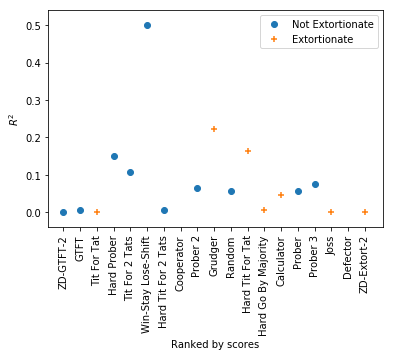

In [303]:
x_tick_locations = range(1, len(players) + 1)

for index, label, marker in zip([~df["Extort"], df["Extort"]], ["Not Extortionate", "Extortionate"], ("o", "+")):
    ranks = df["Score"].rank(ascending=False)[df["complete"] & index]
    plt.scatter(ranks, df[df["complete"] & index]["residual"], label=label, marker=marker)
sorted_indices = sorted(range(len(players)), key=lambda index: -df["Score"].iloc[index])
sorted_players = [players[i].name for i in sorted_indices]
plt.xlabel("Ranked by scores")
plt.ylabel(r"$R^2$")
plt.legend()
plt.xticks(range(1, len(players) + 1), sorted_players, rotation='vertical');

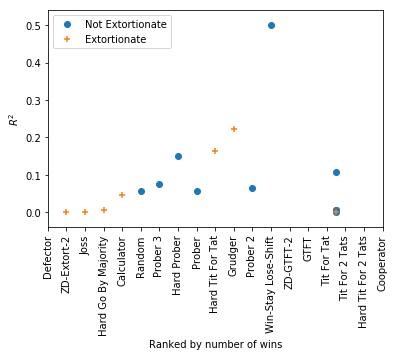

In [304]:
x_tick_locations = range(1, len(players) + 1)

for index, label, marker in zip([~df["Extort"], df["Extort"]], ["Not Extortionate", "Extortionate"], ("o", "+")):
    ranks = df["Win"].rank(ascending=False)[df["complete"] & index]
    plt.scatter(ranks, df[df["complete"] & index]["residual"], label=label, marker=marker)
sorted_indices = sorted(range(len(players)), key=lambda index: -df["Win"].iloc[index])
sorted_players = [players[i].name for i in sorted_indices]
plt.xlabel("Ranked by number of wins")
plt.ylabel(r"$R^2$")
plt.legend()
plt.xticks(range(1, len(players) + 1), sorted_players, rotation='vertical');

We can also consider pair wise matches:

In [312]:
df = pd.read_csv("data/processed/stewart_plotkin/std/per_opponent/main.csv")
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Opponent name"] = df.apply(lambda row: player_names[row["Opponent index"]], axis=1)
df["Extort"] = (df["complete"]) & (df["P(C|DD)"] == 0) & (df["chi"] > 1)

In [313]:
delta_array = np.zeros((len(players), len(players)))
mutual_cooperation_array = np.zeros((len(players), len(players)))

for array in [delta_array, mutual_cooperation_array]:
    array.fill(np.nan)

for index, row in df.iterrows():
    if row["Extort"]:
        delta_array[row["Player index"], row["Opponent index"]] = row["residual"]
    mutual_cooperation_array[row["Player index"], row["Opponent index"]] = row["P(CC)"]

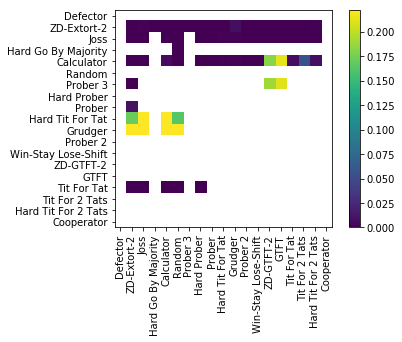

In [314]:
plt.imshow(delta_array[sorted_indices][:,sorted_indices])
plt.colorbar()
plt.xticks(range(len(players)), sorted_players, rotation='vertical')
plt.yticks(range(len(players)), sorted_players);

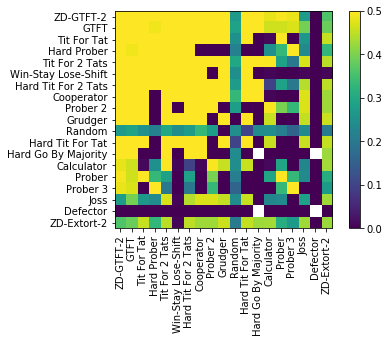

In [169]:
plt.imshow(mutual_cooperation_array[sorted_indices][:,sorted_indices])
plt.colorbar()
plt.xticks(range(len(players)), sorted_players, rotation='vertical')
plt.yticks(range(len(players)), sorted_players);

## Larger tournament

In [170]:
df = pd.read_csv("data/processed/full/std/overall/main.csv")
players = parameters.PLAYER_GROUPS["full"]
player_names = [s.name for s in players]
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Extort"] = (df["complete"]) & (df["P(C|DD)"] == 0) & (- df["beta"] / df["alpha"] > 1)
df.sort_values("Score", ascending=False)

,Player index,complete,Score,Win,P(C|CC),P(C|CD),P(C|DC),P(C|DD),P(CC),P(CD),P(DC),P(DD),residual,alpha,beta,gamma,Player name,Extort
56,56,True,72073078,2818,0.938130,0.498445,0.207358,0.469810,0.425845,0.044913,0.103396,0.058224,4.230097e-02,-0.086267,-0.228050,7.356495e-01,EvolvedLookerUp2_2_2,False
57,57,True,72066777,2511,0.999799,0.465548,0.002483,0.188178,0.446304,0.024411,0.082980,0.068274,8.701581e-02,-0.028165,-0.135553,2.823676e-01,Evolved HMM 5,False
129,129,True,71312376,2495,0.965593,0.182812,0.183294,0.347217,0.416978,0.045803,0.120242,0.085331,1.269716e-01,-0.037352,-0.237448,5.380287e-01,PSO Gambler 2_2_2,False
131,131,True,71175945,2585,1.000000,0.522486,0.000000,0.120535,0.450638,0.020589,0.078134,0.080864,6.426871e-02,-0.012259,-0.107762,1.808025e-01,PSO Gambler Mem1,False
128,128,True,71143493,2705,1.000000,0.282533,0.000000,0.131962,0.448846,0.017370,0.084938,0.093701,1.363980e-01,-0.004769,-0.148262,1.979425e-01,PSO Gambler 1_1_1,False
52,52,True,70988717,2263,0.992589,0.470453,0.000000,0.682802,0.426516,0.054304,0.092663,0.046641,1.642911e-01,-0.167367,-0.273276,1.027908e+00,Evolved FSM 4,False
50,50,True,70816631,2751,0.999898,0.930344,0.001421,0.000000,0.455279,0.002652,0.086789,0.123320,1.030060e-03,0.003300,-0.010916,5.093289e-05,Evolved ANN 5,True
54,54,True,70648934,2595,0.998337,0.637264,0.038748,0.011906,0.456843,0.009737,0.076577,0.103381,2.382690e-02,0.018565,-0.061732,1.868988e-02,Evolved FSM 16 Noise 05,False
53,53,True,70436701,3723,0.928119,0.668755,0.249082,0.192369,0.416233,0.049944,0.117590,0.088639,1.105318e-03,-0.011948,-0.128013,3.244936e-01,Evolved FSM 16,False
49,49,True,70201223,2727,0.999668,0.146135,0.036341,0.085944,0.447872,0.015298,0.088958,0.114793,1.643549e-01,0.019674,-0.158367,1.290819e-01,Evolved ANN,False


In [171]:
df["residual"].describe()

count    202.000000
mean       0.088426
std        0.148468
min        0.000000
25%        0.001624
50%        0.033496
75%        0.136292
max        1.388889
Name: residual, dtype: float64

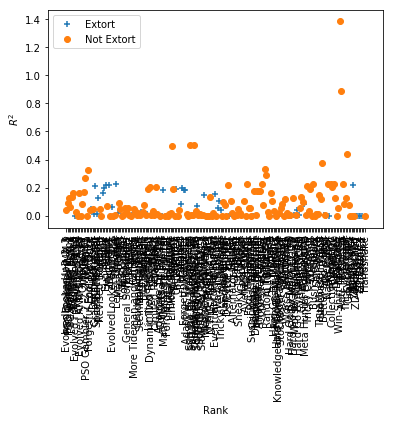

In [172]:
x_tick_locations = range(1, len(players) + 1)

for index, label, marker in zip([df["Extort"], ~df["Extort"]], ["Extort", "Not Extort"], ("+", "o")):
    ranks = df["Score"].rank(ascending=False)[df["complete"] & index]
    plt.scatter(ranks, df[df["complete"] & index]["residual"], label=label, marker=marker)
sorted_indices = sorted(range(len(players)), key=lambda index: -df["Score"].iloc[index])
sorted_players = [players[i].name for i in sorted_indices]
plt.xlabel("Rank")
plt.ylabel(r"$R^2$")
plt.legend()
plt.xticks(range(1, len(players) + 1), sorted_players, rotation='vertical');

In [173]:
df.sort_values("Score", ascending=False).head(20)

,Player index,complete,Score,Win,P(C|CC),P(C|CD),P(C|DC),P(C|DD),P(CC),P(CD),P(DC),P(DD),residual,alpha,beta,gamma,Player name,Extort
56,56,True,72073078,2818,0.938130,0.498445,0.207358,0.469810,0.425845,0.044913,0.103396,0.058224,0.042301,-0.086267,-0.228050,7.356495e-01,EvolvedLookerUp2_2_2,False
57,57,True,72066777,2511,0.999799,0.465548,0.002483,0.188178,0.446304,0.024411,0.082980,0.068274,0.087016,-0.028165,-0.135553,2.823676e-01,Evolved HMM 5,False
129,129,True,71312376,2495,0.965593,0.182812,0.183294,0.347217,0.416978,0.045803,0.120242,0.085331,0.126972,-0.037352,-0.237448,5.380287e-01,PSO Gambler 2_2_2,False
131,131,True,71175945,2585,1.000000,0.522486,0.000000,0.120535,0.450638,0.020589,0.078134,0.080864,0.064269,-0.012259,-0.107762,1.808025e-01,PSO Gambler Mem1,False
128,128,True,71143493,2705,1.000000,0.282533,0.000000,0.131962,0.448846,0.017370,0.084938,0.093701,0.136398,-0.004769,-0.148262,1.979425e-01,PSO Gambler 1_1_1,False
52,52,True,70988717,2263,0.992589,0.470453,0.000000,0.682802,0.426516,0.054304,0.092663,0.046641,0.164291,-0.167367,-0.273276,1.027908e+00,Evolved FSM 4,False
50,50,True,70816631,2751,0.999898,0.930344,0.001421,0.000000,0.455279,0.002652,0.086789,0.123320,0.001030,0.003300,-0.010916,5.093289e-05,Evolved ANN 5,True
54,54,True,70648934,2595,0.998337,0.637264,0.038748,0.011906,0.456843,0.009737,0.076577,0.103381,0.023827,0.018565,-0.061732,1.868988e-02,Evolved FSM 16 Noise 05,False
53,53,True,70436701,3723,0.928119,0.668755,0.249082,0.192369,0.416233,0.049944,0.117590,0.088639,0.001105,-0.011948,-0.128013,3.244936e-01,Evolved FSM 16,False
49,49,True,70201223,2727,0.999668,0.146135,0.036341,0.085944,0.447872,0.015298,0.088958,0.114793,0.164355,0.019674,-0.158367,1.290819e-01,Evolved ANN,False


In [174]:
df.sort_values("Score", ascending=False).head(20)

,Player index,complete,Score,Win,P(C|CC),P(C|CD),P(C|DC),P(C|DD),P(CC),P(CD),P(DC),P(DD),residual,alpha,beta,gamma,Player name,Extort
56,56,True,72073078,2818,0.938130,0.498445,0.207358,0.469810,0.425845,0.044913,0.103396,0.058224,0.042301,-0.086267,-0.228050,7.356495e-01,EvolvedLookerUp2_2_2,False
57,57,True,72066777,2511,0.999799,0.465548,0.002483,0.188178,0.446304,0.024411,0.082980,0.068274,0.087016,-0.028165,-0.135553,2.823676e-01,Evolved HMM 5,False
129,129,True,71312376,2495,0.965593,0.182812,0.183294,0.347217,0.416978,0.045803,0.120242,0.085331,0.126972,-0.037352,-0.237448,5.380287e-01,PSO Gambler 2_2_2,False
131,131,True,71175945,2585,1.000000,0.522486,0.000000,0.120535,0.450638,0.020589,0.078134,0.080864,0.064269,-0.012259,-0.107762,1.808025e-01,PSO Gambler Mem1,False
128,128,True,71143493,2705,1.000000,0.282533,0.000000,0.131962,0.448846,0.017370,0.084938,0.093701,0.136398,-0.004769,-0.148262,1.979425e-01,PSO Gambler 1_1_1,False
52,52,True,70988717,2263,0.992589,0.470453,0.000000,0.682802,0.426516,0.054304,0.092663,0.046641,0.164291,-0.167367,-0.273276,1.027908e+00,Evolved FSM 4,False
50,50,True,70816631,2751,0.999898,0.930344,0.001421,0.000000,0.455279,0.002652,0.086789,0.123320,0.001030,0.003300,-0.010916,5.093289e-05,Evolved ANN 5,True
54,54,True,70648934,2595,0.998337,0.637264,0.038748,0.011906,0.456843,0.009737,0.076577,0.103381,0.023827,0.018565,-0.061732,1.868988e-02,Evolved FSM 16 Noise 05,False
53,53,True,70436701,3723,0.928119,0.668755,0.249082,0.192369,0.416233,0.049944,0.117590,0.088639,0.001105,-0.011948,-0.128013,3.244936e-01,Evolved FSM 16,False
49,49,True,70201223,2727,0.999668,0.146135,0.036341,0.085944,0.447872,0.015298,0.088958,0.114793,0.164355,0.019674,-0.158367,1.290819e-01,Evolved ANN,False


In [179]:
df = pd.read_csv("data/processed/full/std/per_opponent/main.csv")
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Opponent name"] = df.apply(lambda row: player_names[row["Opponent index"]], axis=1)

In [180]:
plt.imshow(delta_array[sorted_indices][:,sorted_indices])
plt.colorbar()
plt.xticks(range(len(players)), sorted_players, rotation='vertical')
plt.yticks(range(len(players)), sorted_players);

IndexError: index 56 is out of bounds for axis 0 with size 19

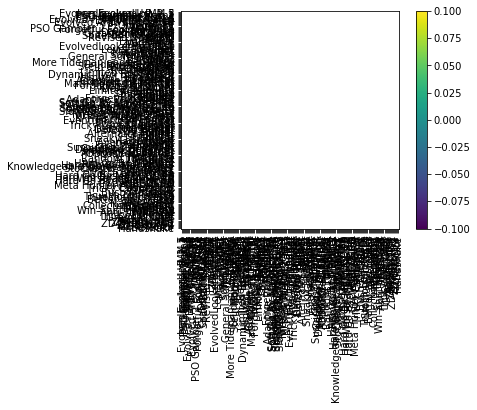

In [177]:
plt.imshow(array[sorted_indices][:,sorted_indices])
plt.colorbar();
plt.xticks(range(len(sorted_players)), sorted_players, rotation='vertical')
plt.yticks(range(len(sorted_players)), sorted_players);

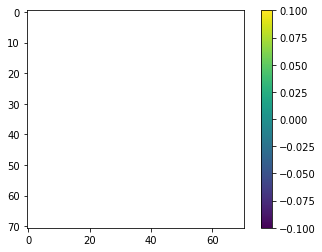

In [178]:
plt.imshow(array[sorted_indices][:,sorted_indices][:71,:71])
plt.colorbar();

## References

[1] Press, William H., and Freeman J. Dyson. "Iterated Prisoner’s Dilemma contains strategies that dominate any evolutionary opponent." Proceedings of the National Academy of Sciences 109.26 (2012): 10409-10413

[2] Stewart, Alexander J., and Joshua B. Plotkin. "Extortion and cooperation in the Prisoner’s Dilemma." Proceedings of the National Academy of Sciences 109.26 (2012): 10134-10135.

[3] Golub, Gene H., and Charles F. Van Loan. Matrix computations. Vol. 3. JHU Press, 2012.

[4] The Axelrod project developers. Axelrod: v4.2.0. 2016. http://doi.org/10.5281/zenodo.1252994

[5] Knight, Vincent, et al. "An Open Framework for the Reproducible Study of the Iterated Prisoner’s Dilemma." Journal of Open Research Software 4.1 (2016).